# 1. Импорт библиотек и загрузка данных

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

file_path = 'data.csv'
data = pd.read_csv(file_path)

print("Первые строки данных:")
print(data.head())

print("\nОбщая информация о данных:")
data.info()
print("\nКоличество пропущенных значений в данных:")
print(data.isnull().sum())


Первые строки данных:
   id          brand              model  model_year  milage      fuel_type  \
0   0           MINI      Cooper S Base        2007  213000       Gasoline   
1   1        Lincoln              LS V8        2002  143250       Gasoline   
2   2      Chevrolet  Silverado 2500 LT        2002  136731  E85 Flex Fuel   
3   3        Genesis   G90 5.0 Ultimate        2017   19500       Gasoline   
4   4  Mercedes-Benz        Metris Base        2021    7388       Gasoline   

                                              engine  \
0       172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
1       252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
2  320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
3       420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4       208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                     transmission ext_col int_col  \
0                             A/T  Yellow    Gray   
1                             A/T  Silver   Beige   
2            

# 2. Исследовательский анализ данных (EDA)

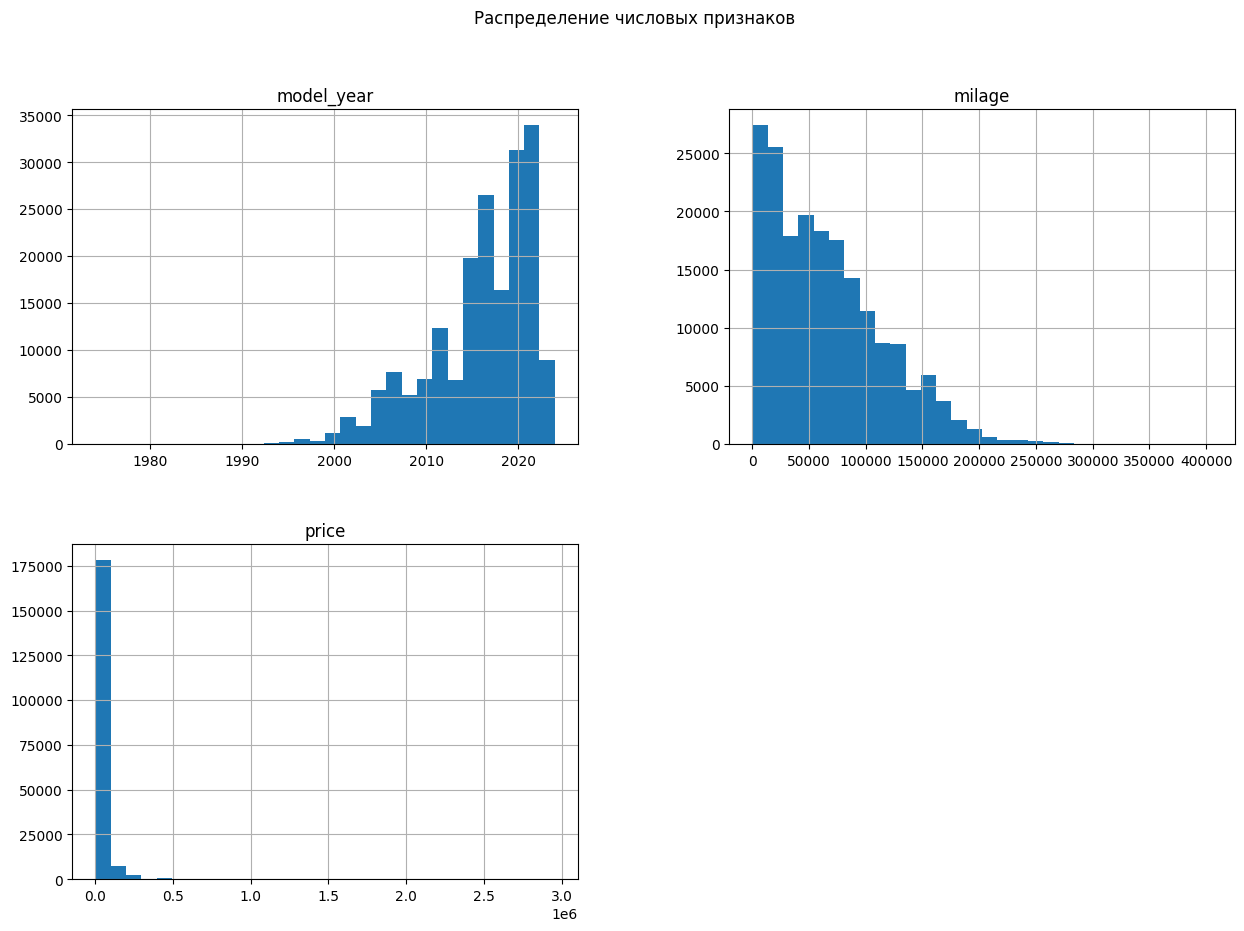

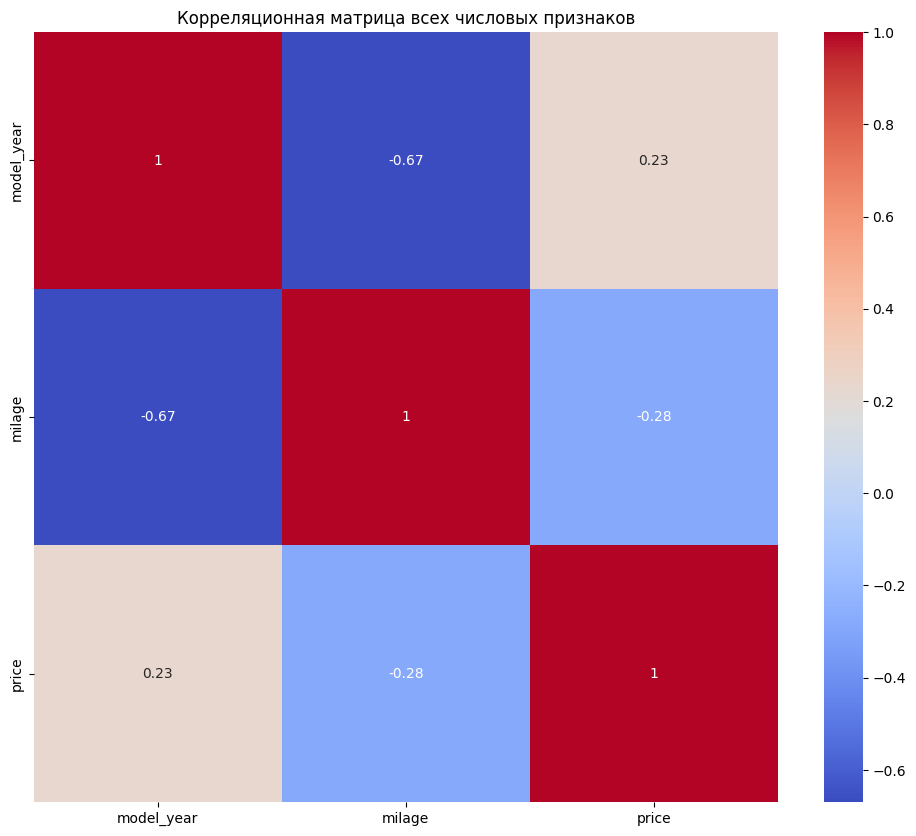

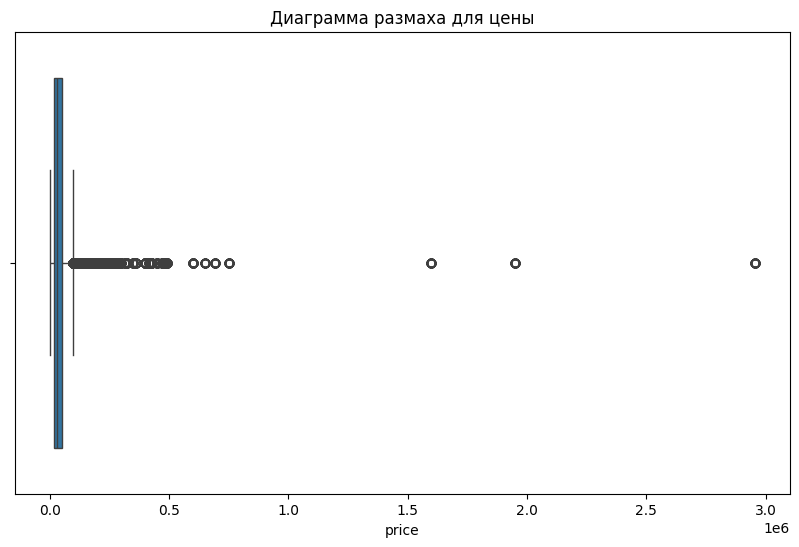

count    1.885330e+05
mean     4.387802e+04
std      7.881952e+04
min      2.000000e+03
25%      1.700000e+04
50%      3.082500e+04
75%      4.990000e+04
max      2.954083e+06
Name: price, dtype: float64


In [88]:
# Убираем колонку 'id' из данных для построения гистограмм и корреляций
data_without_id = data.drop(columns=['id'])

# Гистограммы для числовых признаков
data_without_id.hist(bins=30, figsize=(15, 10))
plt.suptitle("Распределение числовых признаков")
plt.show()

# Анализ корреляций для всех числовых признаков
numerical_features = data_without_id.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(12, 10))
correlation_matrix = data_without_id[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Корреляционная матрица всех числовых признаков")
plt.show()

# Диаграмма размаха для 'price'
plt.figure(figsize=(10, 6))
sns.boxplot(x=data_without_id['price'])
plt.title("Диаграмма размаха для цены")
plt.show()

# Статистическое описание данных
print(data_without_id['price'].describe())


# 3. Предварительная обработка данных

In [89]:
# 1. Обработка колонки "engine"
data['engine_hp'] = data['engine'].str.extract(r'(\d+\.?\d*)HP').astype(float)
data['engine_volume'] = data['engine'].str.extract(r'(\d+\.?\d*)L').astype(float)
data = data.drop(columns=['engine'])

# 2. Преобразование категориальных переменных
# Преобразуем "accident" и "clean_title" в числовой формат
data['accident'] = data['accident'].map({
    'None reported': 0,
    'At least 1 accident or damage reported': 1
})
data['clean_title'] = data['clean_title'].map({
    'Yes': 1,
    'No': 0
})

# Агрегация редких категорий
top_brands = data['brand'].value_counts().nlargest(10).index
data['brand'] = data['brand'].apply(lambda x: x if x in top_brands else 'Other')

# Удаление выбросов в milage
Q1 = data['milage'].quantile(0.25)
Q3 = data['milage'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data = data[(data['milage'] >= lower_bound) & (data['milage'] <= upper_bound)]

# Создание новых признаков
data['car_age'] = 2024 - data['model_year']

# One-hot encoding для категориальных переменных
data = pd.get_dummies(data, columns=['brand', 'model', 'fuel_type', 'transmission', 'ext_col', 'int_col'], drop_first=True)

# Удаление пропущенных значений
data = data.dropna()

# Фильтрация по цене
price_lower_bound = 5000
price_upper_bound = 100000
data = data[(data['price'] >= price_lower_bound) & (data['price'] <= price_upper_bound)]

# Разделение данных
X = data.drop(columns=['price', 'id'])
y = data['price']


In [90]:
print(list(X.dtypes[X.dtypes != bool].index))

['model_year', 'milage', 'accident', 'clean_title', 'engine_hp', 'engine_volume', 'car_age']


Проведем обучение только на числовых данных, так как после проведения экспериментов с 
обучением на категориальных данных с OneHot энкодером значения метрик значительно не изменились:

In [91]:

# Разделение на обучающие и тестовые данные
X_train, X_test, y_train, y_test = train_test_split(X[['model_year', 'milage', 'accident', 'clean_title', 'engine_hp', 'engine_volume', 'car_age']], y, test_size=0.2)

# # Масштабирование данных
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [92]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))


# 5. Подбор оптимального количества соседей

In [93]:
# закомментил, чтобы не ждать 50 минут
# neighbors = range(1, 21)
# cv_scores = []

# for k in neighbors:
#     print(k)
#     knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
#     scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
#     cv_scores.append(-scores.mean())

# # Найдём оптимальное количество соседей
# optimal_k = neighbors[np.argmin(cv_scores)]
# print(f"Оптимальное количество соседей: {optimal_k}")

# 6. Построение итоговой модели и её оценка

In [94]:
from sklearn.metrics import root_mean_squared_error, mean_squared_error
# knn = KNeighborsRegressor(n_neighbors=optimal_k)
knn = KNeighborsRegressor(n_neighbors=12)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'Mean Squared Error: {round(mse)}')
print(f'Root Mean Squared Error: {round(rmse)}')
print(f'Mean Absolute Percentage Error: {round(mape, 3)}')

Mean Squared Error: 185053361
Root Mean Squared Error: 13603
Mean Absolute Percentage Error: 0.389
